# Detector of Racial Bias based on Population Simulation System

## Disclaimer



This is the first draft and does not reflect the final version of the project. 

## Acknowledgement

I'd like to thank Professor Abolfazl Asudeh personally for his support with direction, early idea formulation, and insightful advice that considerably improved the quality of this project.

## Introduction

The primary goal of this project is to assess the bias of the Divvy system based on geography and accessibility by simulating the population of that location and evaluating whether the system is racially and/or gender biased. The goal is to uncover and expose any potential bias using statistical data.

## Research Direction

We would apply the normal procedure to research the issue of Racial Bias. As a result, we would focus on the three main aspects:
1. Data Modeling: We would focus on determining the kind of population data, its source, and its dependability. Furthermore, we would focus on how we would manage and organise statistical population data for the models.
2. Population simulation: we'll try to figure out how we'd choose a participant at random from the population's data. We would specifically focus on a person's race, gender, and location as randomized data.
3. Method of Examination: For each geological input, we would examine its bias in respect to the simulated population. As a result, we will focus on the bias algorithm. Furthermore, we would give a user-friendly interface for users to observe how each simulated human is approaching the place using the supplied data.

## Data Modeling


We would use the data from the two sources: Census Bureau, Federal Communication Commission


### Federal Communication Commission 

With a specific geographic coordinate (including the indormation about the latitude and the longitude), we would need an API to retrieve the FIPS code to feed into the data to the `getDeccennial()` function above. 

In [ ]:
import requests
def getFIPS(lat, long, year = 2020, division = "Block"):
    if division not in {"Block", "County", "State"}:
        raise Exception("The administration division level is not correct")
    try:
        url = "https://geo.fcc.gov/api/census/block/find?latitude=" + \
            str(lat)+"&longitude="+str(long) + "&censusYear=" + \
            str(year)+"&showall=false&format=json"
        response = requests.get(url)
        print(response.text)
        return response.json()[division]["FIPS"]

    except requests.ConnectionError as error:
        print("Cannot connect to the GEO API")
        print(error)


In [ ]:
getFIPS(41.886269657542044, -87.70033108160133, year = 2020)

{"Block":{"FIPS":"170318371002011","bbox":[-87.701359,41.885909,-87.69888,41.886508]},"County":{"FIPS":"17031","name":"Cook County"},"State":{"FIPS":"17","code":"IL","name":"Illinois"},"status":"OK","executionTime":"0"}


'170318371002011'

### Census Bureau Data

We will use the Deccenial Census of Population and Housing Data. In default, we would use the data in year 2020. Furthermore, we would based on the Federal Information Processing Standards (FIPS) to retrieve the data. More information on the data could be found over [here](https://www.census.gov/data/developers/data-sets/decennial-census.html).

Due to the project would concern especially with the racial information, we would retrieve all the data in group P1.

In [ ]:
from numpy.core.shape_base import block
import requests
import pandas as pd
import numpy as np
    
def getDecennialData(fips, for_unit = 'block', dataField = "group(P1)", year = "2020"):
    if (for_unit not in {'state', 'county', 'tract', 'block'}):
        assert("for_unit must be 'state', 'county', 'tract', or 'block' ")
    if len(fips) < 2 :
        assert("FIPS must have length greater than 2")
    
    list_string = ['state:'+ fips[0:2],
                   'county:'+ (fips[2:5] if len(fips) >= 5 else '*'), 
                   'tract:' + (fips[5:11] if len(fips) >= 11 else '*'), 
                   'block:' + (fips[11:15] if len(fips) == 15 else '*')]
    
    while list_string[-1].find(for_unit) == -1 :
        list_string.pop()
    for_unit_string = list_string.pop()
    
    url = "https://api.census.gov/data/"+ year +"/dec/pl?get="+ dataField + \
          "&for="+ for_unit_string + ("&in=" if len(list_string) > 0 else "") + \
          "%20".join(list_string)

    try:
        response = requests.get(url)
        JSONObject = response.json()
        if len(JSONObject)  == 2:
            series = pd.Series(JSONObject[1], index=JSONObject[0]).dropna()
            return series
        else:
            dataframe = pd.DataFrame(data= JSONObject[1:], columns=JSONObject[0])
            dataframe.sort_values(by=["GEO_ID"], inplace=True, ignore_index=True)
            print(dataframe)
            return dataframe
            
    except requests.ConnectionError as error:
        print("Cannot connect to the Census API")
        print(error)


def getDecennialDescription():
    try:
        url = "https://api.census.gov/data/2020/dec/pl/variables"
        response = requests.get(url)
        JSONObject = np.array(response.json())
        series = pd.Series(JSONObject[:, 1], index=JSONObject[:, 0])
        series.loc["state"] = "State FIPS"
        series.loc["county"] = "County FIPS"
        series.loc["tract"] = "Tract FIPS"
        series.loc["block"] = "Block FIPS"
        series.loc["NAME"] = "NAME"
        return series

    except requests.ConnectionError as error:
        print("Cannot connect to the Census API")
        print(error)



For instance, we would want to retrieve the Racial data at East Campus of UIC which has the FIPS of `170318419002012`, we would run the function

In [ ]:
getDecennialData("170318419002012")

GEO_ID                              1000000US170318419002012
NAME       Block 2012, Block Group 2, Census Tract 8419, ...
P1_001N                                                    0
P1_002N                                                    0
P1_003N                                                    0
                                 ...                        
P1_071N                                                    0
state                                                     17
county                                                   031
tract                                                 841900
block                                                   2012
Length: 77, dtype: object

Similarly, we would want to retrieve the tract data the has the same county FIPS of `17031`, we would run the function

In [ ]:
getDecennialData("17031", for_unit='tract')

                    GEO_ID                                        NAME  \
0     1400000US17031010100     Census Tract 101, Cook County, Illinois   
1     1400000US17031010201  Census Tract 102.01, Cook County, Illinois   
2     1400000US17031010202  Census Tract 102.02, Cook County, Illinois   
3     1400000US17031010300     Census Tract 103, Cook County, Illinois   
4     1400000US17031010400     Census Tract 104, Cook County, Illinois   
...                    ...                                         ...   
1327  1400000US17031844600    Census Tract 8446, Cook County, Illinois   
1328  1400000US17031844700    Census Tract 8447, Cook County, Illinois   
1329  1400000US17031980000    Census Tract 9800, Cook County, Illinois   
1330  1400000US17031980100    Census Tract 9801, Cook County, Illinois   
1331  1400000US17031990000    Census Tract 9900, Cook County, Illinois   

     P1_001N P1_001NA P1_002N P1_002NA P1_003N P1_003NA P1_004N P1_004NA  ...  \
0       4905     None    4411 

,GEO_ID,NAME,P1_001N,P1_001NA,P1_002N,P1_002NA,P1_003N,P1_003NA,P1_004N,P1_004NA,...,P1_068NA,P1_069N,P1_069NA,P1_070N,P1_070NA,P1_071N,P1_071NA,state,county,tract
0,1400000US17031010100,"Census Tract 101, Cook County, Illinois",4905,None,4411,None,1652,None,2187,None,...,None,0,None,0,None,0,None,17,031,010100
1,1400000US17031010201,"Census Tract 102.01, Cook County, Illinois",6939,None,6141,None,1832,None,2574,None,...,None,0,None,0,None,0,None,17,031,010201
2,1400000US17031010202,"Census Tract 102.02, Cook County, Illinois",2742,None,2425,None,1078,None,767,None,...,None,0,None,0,None,0,None,17,031,010202
3,1400000US17031010300,"Census Tract 103, Cook County, Illinois",6305,None,5511,None,2963,None,1778,None,...,None,0,None,0,None,0,None,17,031,010300
4,1400000US17031010400,"Census Tract 104, Cook County, Illinois",5079,None,4675,None,3148,None,620,None,...,None,0,None,0,None,0,None,17,031,010400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1327,1400000US17031844600,"Census Tract 8446, Cook County, Illinois",1776,None,1736,None,55,None,1647,None,...,None,0,None,0,None,0,None,17,031,844600
1328,1400000US17031844700,"Census Tract 8447, Cook County, Illinois",2342,None,2196,None,143,None,1821,None,...,None,0,None,0,None,0,None,17,031,844700
1329,1400000US17031980000,"Census Tract 9800, Cook County, Illinois",0,None,0,None,0,None,0,None,...,None,0,None,0,None,0,None,17,031,980000
1330,1400000US17031980100,"Census Tract 9801, Cook County, Illinois",18,None,14,None,6,None,3,None,...,None,0,None,0,None,0,None,17,031,980100


## Principles of data simulation
We'd mimic the data using the Geographic Hierachy shown below. However, in the figure below, we would just concentrate on the State level down to the Block level.
This includes the following:

1. State

2. Counties

3. Block Groups

4. Census Blocks


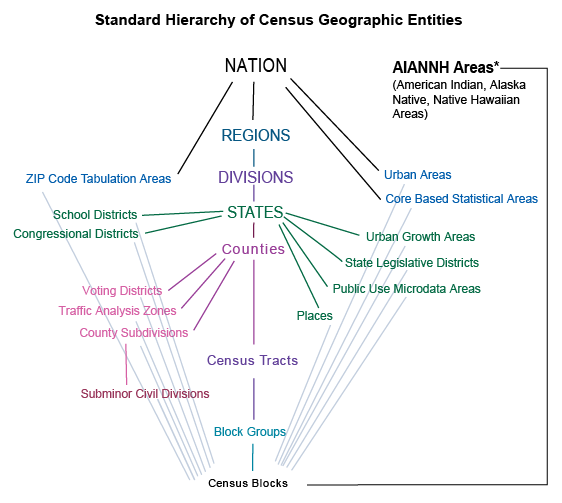

## Design Pattern for data retrieval
In order to give the best efficiency in data retrieval, we must create a way to minimize the total data API requests and maximize the reuse of the data. Therefore, we decided to use:
1. Singleton Design Pattern: The singleton design pattern limits a class's instantiation to a single instance. This is done to enable coordinated access to a certain resource throughout an entire software system. The singleton class uses this design pattern to guarantee that it is only created once and may enable simple access to the one instance. We'd utilize this to reduce the number of Block instantiations required for various randomized functions in State classes that use Block data and operations.
2. Component Design Pattern: The composite pattern is a partitioning design pattern that specifies a set of items that are processed as if they were a single instance of the same kind of object. A composite's goal is to "compose" things into tree structures that depict part-whole hierarchies. It enables you to create a tree structure and assign tasks to each node in the tree structure. We would use this in the need of evoke smaller operations from the bigger classes. For instance, we would want to access a `Block` operation from the `State` level.
3. Template Method: An abstract class provides specified methods (templates) for executing its methods. Its subclasses may alter the method implementation as needed, but invocation must follow the rules provided by an abstract class. This pattern falls under the area of behavioural patterns. We would use this strategy to develop a number of classes that all perform the same purpose. A 'Block,' for example, may be formed by performing an API call or obtaining a data record from the State. As a result, we'd have `BlockByAPI` and `BlockByState`, which are essentially the same thing but different in how the data is retrieved.


## Person
This is the profile for a person in the simulation. It will contains:
1. Person's current block
2. The race of that person
3. The location of that person based on the block

In [42]:
class Person():
    def __init__(self, blockFIPS, race):
        self._blockFIPS = blockFIPS
        self._race = race
        self._location = None

    @property
    def blockFIPS(self):
        return self._blockFIPS
    
    @property
    def race(self):
        return self._race

    @property
    def location(self):
        if (self._location is None):
          # "INTPTLAT, INTPTLON" // still working on this
            print(getDecennialData(self._blockFIPS, dataField = "TRISUBREM"))
        return self._location

    @location.setter
    def censusYear(self, location):
      self._location = location

    def __repr__(self):
      return f"<Person block_FIPS:{self._blockFIPS}, race:{self._race}>"

For instance, here is an example person:

In [43]:
newPerson = Person("170318371002011", "P1_003N")
newPerson

<Person block_FIPS:170318371002011, race:P1_003N>

## Plotting function
This function helps plotting a sample


In [44]:
def plotSample(sample):
    sample = pd.Series([person.race for person in sample]).value_counts().sort_index()
    sample.plot(kind = "bar")
    plt.show()

## Unit

Each State, each Block, each County, each Tract is an administrative unit. Therefore, we can build an abstract administrative unit class as follows:

In [45]:
from abc import ABC, abstractmethod

class UnitInterface(ABC):
    def __init__(self):
        pass

    @property
    @abstractmethod
    def FIPS(self):
      pass

    @property
    @abstractmethod
    def censusYear(self):
      pass
    
    @property
    @abstractmethod
    def decennialData(self):
      pass

    @property
    @abstractmethod
    def decennialDataCumulative(self):
      pass

    @abstractmethod
    def getSample(self):
      pass

    @abstractmethod
    def graphDecennialData(self):
      pass
  

In [46]:
import numpy as np
import pandas as pd

class Unit(UnitInterface):
    def __init__(self, administrativeUnit):
      self._administrative_unit = administrativeUnit
      self._FIPS = None
      self._censusYear = None
      self._decennial_data = None
      self._decennial_data_cumulative = None
    
    @property
    def administrativeUnit(self):
        return self._administrative_unit

    @property
    def FIPS(self):
        return self._FIPS

    @FIPS.setter
    def FIPS(self, fips):
      self._FIPS = fips
    
    @property
    def censusYear(self):
        return self._censusYear

    @censusYear.setter
    def censusYear(self, censusYear):
      self._censusYear = censusYear
    
    @property
    def decennialData(self):
        return self._decennial_data

    @decennialData.setter
    def decennialData(self, decennial_data):
        self._decennial_data = decennial_data

    @property
    def decennialDataCumulative(self):
        if (self._decennial_data_cumulative is None):
            decennial_data_processed = pd.to_numeric(self.decennialData.get(
                            ['P1_003N', 'P1_004N', 'P1_005N',
                            'P1_006N', 'P1_007N', 'P1_008N', 'P1_011N',
                            'P1_012N', 'P1_013N', 'P1_014N', 'P1_015N', 'P1_016N', 'P1_017N',
                            'P1_018N', 'P1_019N', 'P1_020N', 'P1_021N', 'P1_022N', 'P1_023N',
                            'P1_024N', 'P1_025N', 'P1_027N', 'P1_028N', 'P1_029N',
                            'P1_030N', 'P1_031N', 'P1_032N', 'P1_033N', 'P1_034N', 'P1_035N',
                            'P1_036N', 'P1_037N', 'P1_038N', 'P1_039N', 'P1_040N', 'P1_041N',
                            'P1_042N', 'P1_043N', 'P1_044N', 'P1_045N', 'P1_046N', 
                            'P1_048N', 'P1_049N', 'P1_050N', 'P1_051N', 'P1_052N', 'P1_053N',
                            'P1_054N', 'P1_055N', 'P1_056N', 'P1_057N', 'P1_058N', 'P1_059N',
                            'P1_060N', 'P1_061N', 'P1_062N', 'P1_063N', 'P1_064N', 'P1_065N',
                            'P1_066N', 'P1_067N', 'P1_068N', 'P1_069N', 'P1_071N']))
            decennial_data_processed = decennial_data_processed[decennial_data_processed > 0]
            if (decennial_data_processed.size == 0):
                print('No Population')
            self._decennial_data_cumulative = decennial_data_processed.cumsum()
            self._decennial_data_cumulative = self._decennial_data_cumulative * 1.0 / self._decennial_data_cumulative.max()
        return self._decennial_data_cumulative

    @decennialDataCumulative.setter
    def decennialDataCumulative(self, decennial_data_cumulative):
        self._decennial_data_cumulative = decennial_data_cumulative

    def __repr__(self):
        return f"<Unit administrative_unit:{self._administrative_unit}, \n    FIPS:{self._FIPS}, \n    decennial_data: \n {self.decennialData}>"

    def getSample(self, n = 1):
        randomFloat = np.random.random_sample(size = n)
        indexNum = self.decennialDataCumulative.searchsorted(randomFloat, side="right")
        return list(map((lambda x : Person(self._FIPS, self.decennialDataCumulative.index[x])), indexNum))

    def graphDecennialData(self):
        self.getProcessedDecennialData()
        self._decennial_data.plot( kind = 'bar')
        plt.show()

We would able to create each administrative unit based on their FIPS.

### Block

In [47]:
import matplotlib.pyplot as plt
class BlockByFIPS(Unit):
    def __init__(self, FIPS, censusYear = "2020"):  
      super().__init__("Block")
      if (len(FIPS) != 15):
          raise Exception("fips length is invalid")
      self._FIPS = FIPS
      self._censusYear = censusYear

    @property
    def decennialData(self):
        if(self._decennial_data is None):
            self._decennial_data = getDecennialData(self._FIPS, year = self._censusYear)
        return self._decennial_data



In [48]:
newBlock = BlockByFIPS("170318371002011")
newBlock

<Unit administrative_unit:Block, 
    FIPS:170318371002011, 
    decennial_data: 
 GEO_ID                              1000000US170318371002011
NAME       Block 2011, Block Group 2, Census Tract 8371, ...
P1_001N                                                   59
P1_002N                                                   54
P1_003N                                                   25
                                 ...                        
P1_071N                                                    0
state                                                     17
county                                                   031
tract                                                 837100
block                                                   2011
Length: 77, dtype: object>

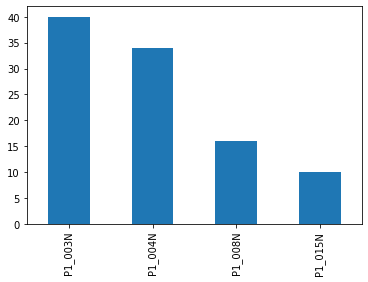

In [49]:
sample = newBlock.getSample(100)
plotSample(sample)

### Tract

In [50]:
import matplotlib.pyplot as plt
class TractByFIPS(Unit):
    def __init__(self, FIPS, censusYear = "2020"):  
      super().__init__("Tract")
      if (len(FIPS) != 11):
          raise Exception("fips length is invalid")
      self._FIPS = FIPS
      self._censusYear = censusYear

    @property
    def decennialData(self):
        if(self._decennial_data is None):
            self._decennial_data = getDecennialData(self._FIPS, year = self._censusYear, for_unit="tract")
        return self._decennial_data



In [51]:
newTract = TractByFIPS("17031837100")
newTract

<Unit administrative_unit:Tract, 
    FIPS:17031837100, 
    decennial_data: 
 GEO_ID                         1400000US17031837100
NAME       Census Tract 8371, Cook County, Illinois
P1_001N                                        1652
P1_002N                                        1536
P1_003N                                         240
                             ...                   
P1_070N                                           0
P1_071N                                           0
state                                            17
county                                          031
tract                                        837100
Length: 76, dtype: object>

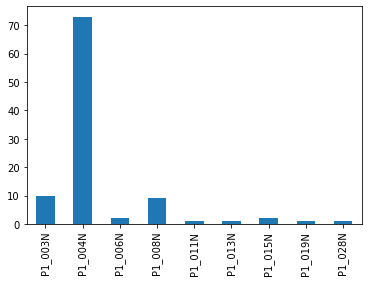

In [52]:
sample = newTract.getSample(100)
plotSample(sample)

### County

In [53]:
import matplotlib.pyplot as plt
class CountyByFIPS(Unit):
    def __init__(self, FIPS, censusYear = "2020"):  
      super().__init__("County")
      if (len(FIPS) != 5):
          raise Exception("fips length is invalid")
      self._FIPS = FIPS
      self._censusYear = censusYear

    @property
    def decennialData(self):
        if(self._decennial_data is None):
            self._decennial_data = getDecennialData(self._FIPS, year = self._censusYear, for_unit="county")
        return self._decennial_data



In [54]:
newCounty = CountyByFIPS("17031")
newCounty

<Unit administrative_unit:County, 
    FIPS:17031, 
    decennial_data: 
 GEO_ID            0500000US17031
NAME       Cook County, Illinois
P1_001N                  5275541
P1_002N                  4728989
P1_003N                  2345983
                   ...          
P1_069N                        1
P1_070N                       36
P1_071N                       36
state                         17
county                       031
Length: 75, dtype: object>

[<Person block_FIPS:17031, race:P1_004N>, <Person block_FIPS:17031, race:P1_003N>, <Person block_FIPS:17031, race:P1_008N>, <Person block_FIPS:17031, race:P1_003N>, <Person block_FIPS:17031, race:P1_003N>, <Person block_FIPS:17031, race:P1_008N>, <Person block_FIPS:17031, race:P1_003N>, <Person block_FIPS:17031, race:P1_003N>, <Person block_FIPS:17031, race:P1_004N>, <Person block_FIPS:17031, race:P1_003N>, <Person block_FIPS:17031, race:P1_012N>, <Person block_FIPS:17031, race:P1_003N>, <Person block_FIPS:17031, race:P1_003N>, <Person block_FIPS:17031, race:P1_004N>, <Person block_FIPS:17031, race:P1_003N>, <Person block_FIPS:17031, race:P1_015N>, <Person block_FIPS:17031, race:P1_004N>, <Person block_FIPS:17031, race:P1_003N>, <Person block_FIPS:17031, race:P1_015N>, <Person block_FIPS:17031, race:P1_015N>, <Person block_FIPS:17031, race:P1_006N>, <Person block_FIPS:17031, race:P1_015N>, <Person block_FIPS:17031, race:P1_015N>, <Person block_FIPS:17031, race:P1_003N>, <Person block_F

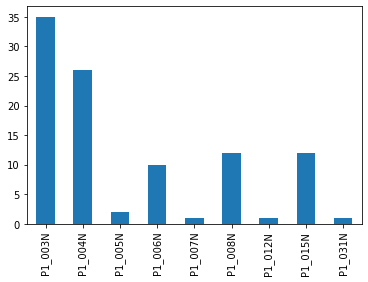

In [55]:
sample = newCounty.getSample(100)
print(sample)
plotSample(sample)

In [56]:
getFIPS(41.886269657542044, -87.70033108160133, year = "2020")

{"Block":{"FIPS":"170318371002011","bbox":[-87.701359,41.885909,-87.69888,41.886508]},"County":{"FIPS":"17031","name":"Cook County"},"State":{"FIPS":"17","code":"IL","name":"Illinois"},"status":"OK","executionTime":"0"}


'170318371002011'

### State

In [57]:
import matplotlib.pyplot as plt
class StateByFIPS(Unit):
    def __init__(self, FIPS, censusYear = "2020"):  
      super().__init__("State")
      if (len(FIPS) != 2):
          raise Exception("fips length is invalid")
      self._FIPS = FIPS
      self._censusYear = censusYear

    @property
    def decennialData(self):
        if(self._decennial_data is None):
            self._decennial_data = getDecennialData(self._FIPS, year = self._censusYear, for_unit="state")
        return self._decennial_data



In [58]:
newState = StateByFIPS("17")
newState

<Unit administrative_unit:State, 
    FIPS:17, 
    decennial_data: 
 GEO_ID     0400000US17
NAME          Illinois
P1_001N       12812508
P1_002N       11667524
P1_003N        7868227
              ...     
P1_068N              4
P1_069N             15
P1_070N             84
P1_071N             84
state               17
Length: 74, dtype: object>

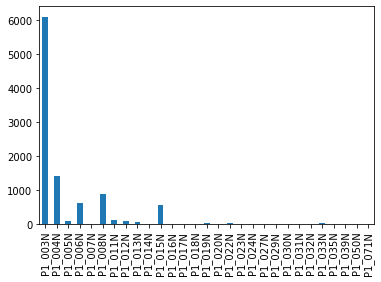

In [59]:
sample = newState.getSample(10000)
plotSample(sample)

## Geolocation inputs
Working with input from latitude and longitude, we can convert it into FIPS using the API from Federal Communication Commission using the `getFIPS()` function. 

In [60]:
class BlockByLoc(BlockByFIPS):
    def __init__(self, lat, lon, censusYear = "2020"):  
        FIPS = getFIPS(lat, lon, year = censusYear)
        super().__init__(FIPS, censusYear)

class CountyByLoc(CountyByFIPS):
    def __init__(self, lat, lon, censusYear = "2020"):  
        FIPS = getFIPS(lat, lon, year = censusYear, division="County")
        super().__init__(FIPS, censusYear)

class StateByLoc(StateByFIPS):
    def __init__(self, lat, lon, censusYear = "2020"):  
        FIPS = getFIPS(lat, lon, year = censusYear, division="State")
        super().__init__(FIPS, censusYear)


For instance, we get the County data based on `lat=41.871939, lon=-87.649470`:

In [61]:
newCounty = CountyByLoc(lat=41.871939, lon=-87.649470)
newCounty

{"Block":{"FIPS":"170318419001043","bbox":[-87.651808,41.869508,-87.647064,41.874375]},"County":{"FIPS":"17031","name":"Cook County"},"State":{"FIPS":"17","code":"IL","name":"Illinois"},"status":"OK","executionTime":"0"}


<Unit administrative_unit:County, 
    FIPS:17031, 
    decennial_data: 
 GEO_ID            0500000US17031
NAME       Cook County, Illinois
P1_001N                  5275541
P1_002N                  4728989
P1_003N                  2345983
                   ...          
P1_069N                        1
P1_070N                       36
P1_071N                       36
state                         17
county                       031
Length: 75, dtype: object>

# Group
Assume you want to gather information and analyze of a list of `Block` that have the same `State` FIPS, we would use this class.

### Unit By Decennial Data

For each retrieval of `Group` data, we would obtain a large table of `Unit` data. Therefore, a new class of `Unit` is required that can accept input from a sequence of `DecennialData`.

In [62]:
class UnitByDecennialData(Unit):
    def __init__(self, decennialData, cummulativeDecennialData = None):
        if not isinstance(decennialData, pd.Series):
            raise("The DecennialData must be a panda Series")
        if ('state' in decennialData.index):
            state = str(decennialData['state'])
            self._administrative_unit = 'State'
            print(state)
        else:
            state = ""
        
        if ('county' in decennialData.index):
            county = str(decennialData['county'])
            self._administrative_unit = 'County'
            print(county)
        else:
            county = ""

        if ('tract' in decennialData.index):
            tract = str(decennialData['tract'])
            self._administrative_unit = 'Tract'
            print(tract)
        else:
            tract = ""

        if ('block' in decennialData.index):
            block = str(decennialData['block'])
            self._administrative_unit = 'Block'
            print(block)
        else:
            block = ""
        
        self._FIPS = state + county + tract + block
        self._censusYear = None
        self._decennial_data = decennialData
        self._decennial_data_cumulative = cummulativeDecennialData

In [63]:
newTract = UnitByDecennialData(getDecennialData("17031841900", for_unit='tract'))
print(newTract)

17
031
841900
<Unit administrative_unit:Tract, 
    FIPS:17031841900, 
    decennial_data: 
 GEO_ID                         1400000US17031841900
NAME       Census Tract 8419, Cook County, Illinois
P1_001N                                        6500
P1_002N                                        6152
P1_003N                                        2542
                             ...                   
P1_070N                                           0
P1_071N                                           0
state                                            17
county                                          031
tract                                        841900
Length: 76, dtype: object>


## Reference
Bureau, U. S. C. (2022, March 10). *Decennial Census (2020, 2010, 2000)*. Census.gov. Retrieved July 14, 2022, from https://www.census.gov/data/developers/data-sets/decennial-census.html 

### Group class

In [64]:
class Group(UnitInterface):
    def __init__(self, FIPS, group_level, unit_level):
        self._administrative_unit = group_level
        self._FIPS = FIPS
        self._unit_level = unit_level
        self._decennial_data = None
        self._decennial_data_cumulative = None
        self._units = []

    @property
    def administrativeUnit(self):
        return self._administrative_unit

    @property
    def FIPS(self):
        return self._FIPS

    @FIPS.setter
    def FIPS(self, fips):
      self._FIPS = fips
    
    @property
    def censusYear(self):
        return self._censusYear

    @censusYear.setter
    def censusYear(self, censusYear):
      self._censusYear = censusYear
    
    @property
    def decennialData(self):
        return self._decennial_data

    @decennialData.setter
    def decennialData(self, decennial_data):
        self._decennial_data = decennial_data

    @property
    def Units(self):
        return self._units

    @property
    def decennialDataCumulative(self):
        if (self._decennial_data_cumulative is None):
            decennial_data_processed = self.decennialData['P1_001N']
            decennial_data_processed = decennial_data_processed[decennial_data_processed > 0]
            if (decennial_data_processed.size == 0):
                print('No Population')
            self._decennial_data_cumulative = decennial_data_processed
            self._decennial_data_cumulative = self._decennial_data_cumulative * 1.0 / self._decennial_data_cumulative.max()
        return self._decennial_data_cumulative

    @decennialDataCumulative.setter
    def decennialDataCumulative(self, decennial_data_cumulative):
        self._decennial_data_cumulative = decennial_data_cumulative

    def __repr__(self):
        return f"<Group administrative_unit:{self._administrative_unit}, \n     FIPS:{self._FIPS}, \n    decennial_data: \n {self.decennialData}>"

    def getSample(self, n = 1):
        randomFloat = np.random.random_sample(size = n)
        indexNum = self.decennialDataCumulative.searchsorted(randomFloat, side="right")
        print(indexNum)
        return list(map((lambda x : self.decennialDataCumulative.index[x]), indexNum))

    def graphDecennialData(self):
        self.getProcessedDecennialData()
        self._decennial_data.plot( kind = 'bar')
        plt.show()

In [64]:
class StateByBlockGroup(Group):
      